In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np

# importing Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.providers.aer import AerSimulator

# import basic plot tools
from qiskit.visualization import plot_histogram

# Herramientas del Qiskit textbook
from qiskit_textbook.tools import random_state, array_to_latex

# Simuladores
sim = AerSimulator()
sim_u = AerSimulator(method='unitary')

The QPE algorithm is one of the most important in QC, and is central to more complex algorithms.

Given a unitary matrix $U$ and one of its eigenvectors (or eigenstates) $|\psi\rangle$, QFT determines the eigenvalue $e^{\boldsymbol{2\pi i}\theta}$ associated.

$$
U|\psi\rangle = e^{\boldsymbol{2\pi i}\theta}|\psi\rangle
$$
Being $U$ unitary, all its eigenvalues are complex numbers of norm 1, so they can be written as $e^{\boldsymbol{2\pi i}\theta}$.
<details>
    <summary><p style="color:blue">Click here for the proof</p></summary>
    
If $U$ is unitary, it verifies $U^\dagger U = UU^\dagger = I$. Let $|v\rangle$ be an eigenvector of $U$ and $\lambda\in \mathbb{C}$ the associated eigenvalue. We have:

$$
U|v\rangle = \lambda|v\rangle \Rightarrow \langle v|v\rangle = \langle v|U^\dagger U|v\rangle = \langle v|\lambda^*\lambda|v\rangle \Rightarrow \langle v|v\rangle = |\lambda|^2 \langle v|v\rangle 
$$
    
Assuming $\lambda \ne 0$, for the equality to hold it is necessary that $|\lambda|^2 = 1 \Rightarrow \lambda = e^{i\phi}$ with $\phi\in\mathbb{R}$.
</details>


The circuit for QPE is the following:

![QPE](images/qpe_tex_qz.png)

The upper register contains $t$ ancilla qubits and the lower one is in the eigenstate $|\psi\rangle$ of $U$. At the output, the state $|2^t\theta\rangle$ is obtained in the ancilla bits.

The idea of the algorithm is to use _phase-kickback_ to transfer rotations proportional to the phase $e^{\boldsymbol{2\pi i}\theta}$ in the Fourier basis, and then apply an inverse QFT to switch to the computational basis. 
<details>
    Phase kickback is a phenomenon that occurs when a controlled operation is applied to two qubits, one of which is in a superposition of states. The relative phase of the superposition is transferred to the control qubit, causing it to become entangled with the target qubit.
</details>

The number $t$ of ancilla bits will determine the precision of the result.

Steps:

i. Initial state: $$ |\psi_0\rangle = \lvert 0 \rangle^{\otimes t} \lvert \psi \rangle$$
ii. After the $H$ gates are applied to the ancilla qubits

$$ 
\begin{aligned}
|\psi_1\rangle &= \frac{1}{\sqrt{2^t}}\left(|0\rangle +|1\rangle \right)^{\otimes t} \lvert \psi \rangle\\[5pt]
&=\frac{1}{\sqrt{2^t}}\left[\left(|0\rangle +|1\rangle\right)\otimes\left(|0\rangle +|1\rangle\right)\otimes\cdots\otimes\left(|0\rangle +|1\rangle\right)\right]\otimes|\psi\rangle
\end{aligned}
$$

iii. We apply the first controlled gate $U^{2^{t-1}}$. First, we can see that, as $U|\psi\rangle = e^{\boldsymbol{2\pi i}\theta}|\psi\rangle$ we will have:

$$
U^{2^{j}}|\psi\rangle = U^{2^{j}-1}U|\psi\rangle = U^{2^{j}-1}e^{\boldsymbol{2\pi i}\theta}|\psi\rangle =\cdots =e^{\boldsymbol{2\pi} i2^{j}\theta}|\psi \rangle
$$

Therefore, the state after applying the controlled $U^{2^{t-1}}$ the phase-kickback transfers the phase to the first qubit:

$$
\begin{aligned}
|\psi_2\rangle &= 
\frac{1}{\sqrt{2^t}}\left[\left(|0\rangle +e^{\boldsymbol{2\pi} i2^{t-1}\theta}|1\rangle\right)\otimes\left(|0\rangle +|1\rangle\right)\otimes\cdots\otimes\left(|0\rangle +|1\rangle\right)\right]\otimes|\psi\rangle
\end{aligned}
$$

iv. Doing the same with the rest of the controlled $U$, we will have that the state before the inverse QFT will be:

$$
|\psi_3\rangle =
\frac{1}{\sqrt{2^t}}\left[\left(|0\rangle +e^{\boldsymbol{2\pi} i2^{t-1}\theta}|1\rangle\right)\otimes\left(|0\rangle +e^{\boldsymbol{2\pi} i2^{t-2}\theta}|1\rangle\right)\otimes\cdots\\
\otimes
\left(|0\rangle +e^{\boldsymbol{2\pi} i2^{1}\theta}|1\rangle\right)\otimes
\left(|0\rangle +e^{\boldsymbol{2\pi} i2^{0}\theta}|1\rangle\right)\right]|\psi\rangle
$$

v. Application of the inverse QFT. We saw that:

$$
U_{QFT}|z\rangle
=\frac{1}{\sqrt{2^n}}\left[
\left(\vert0\rangle + e^{{\frac{2\pi i}{2}z}} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}z} \vert1\rangle\right) 
\otimes  
\cdots\\
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}z} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}z} \vert1\rangle\right)
\right]
$$

Replacing $n$ by $t$ and making $z = 2^t\theta$ in this expression, it is easy to see that the state of the ancilla bits is:

$$
|\psi_3^\text{ancilla}\rangle = U_{QFT}|2^t\theta\rangle
$$

So the state of the ancilla qubits after applying the inverse QFT will be $|\tilde{\theta}\rangle_{t}$, being $\tilde{\theta} =2^t\theta\Rightarrow\theta=\tilde{\theta}/{2^t}$.

By measuring the ancilla bits we obtain the value  $2^t\theta$.


#### Generalization

Let $\{|u_j\rangle\}$ be the basis formed by the eigenvectors of $U$, being the eigenvalues $\lambda_j=e^{2\pi i\theta_j}$. We can express any state $|\psi\rangle$ in that basis:

$$|\psi\rangle = \sum_{j=0}^{N-1} a_j|u_j\rangle$$

Therefore:

$$
U|\psi\rangle = \sum_{j=0}^{N-1} a_j U|u_j\rangle = \sum_{j=0}^{N-1} a_j \lambda_j|u_j\rangle =
\sum_{j=0}^{N-1} a_j e^{2\pi i\theta_j}|u_j\rangle
$$

If we use $|\psi\rangle$ as input in QPE, at the output we will obtain a superposition of the eigenvalues of $U$:

$$\text{QPE}(U, |0\rangle_t|\psi\rangle) = \sum_{j=0}^{N-1} a_j|\tilde{\theta}_j\rangle|u_j\rangle$$

Any measurement of the ancilla bits, returns an eigenvalue of $U$.


#### Example

Calculate the eigenvalue associated with the eigenvector $|1\rangle$ of the T gate

<details>
The T quantum gate is a single-qubit operation that applies a 45-degree ($\frac{\pi}{4}$) phase shift to the |1⟩ state.The eigenvalue of the T gate is a complex number of the form $e^{\boldsymbol{2\pi i}\theta}$, where $\theta$ is the phase associated with the eigenvector. For the T gate, the eigenvectors are $\{|0\rangle,|1\rangle\}$, and the eigenvalues are $\lambda_0 = 1$ and $\lambda_1=e^{\boldsymbol{i\frac{\pi}{4}}}$, so $\theta_0=0$ and $\theta_1=1/8$.  
</details>

$$
T = 
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\ 
\end{bmatrix}
$$

Therefore:
$$ T|1\rangle = 
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\ 
\end{bmatrix}
\begin{bmatrix}
0\\
1\\ 
\end{bmatrix}
= e^\frac{i\pi}{4}|1\rangle = e^{2i\pi\theta}|1\rangle$$

with $$\theta = \frac{1}{8}$$

QPE returns $\tilde{\theta} = 2^t\theta$, so:
$$
\theta = \frac{\tilde{\theta}}{2^t}
$$


We will use 3 ancilla qubits and 1 qubit for the initial state $|\psi\rangle=|1\rangle$.


/opt/conda/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


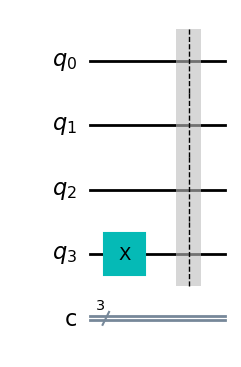

In [2]:
t = 3
# 4 qubits and 3 classical bits to measure the ancillas
qpe = QuantumCircuit(t+1, t)  
qpe.x(t)    # Initial state |1>
qpe.barrier()
qpe.draw('mpl')

Apply the Hadamard gate to the ancillas

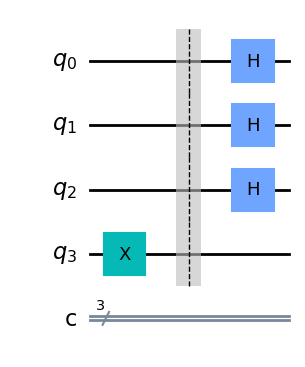

In [3]:
for qubit in range(t):
    qpe.h(qubit)
qpe.draw('mpl')

We apply the controlled rotations $\pi/4$ to the ancillas, remembering that the qubits in Qiskit are ordered in reverse order, so the $U^{2^2}$ will be controlled by $q_2$ and the $U^{2^0}$ by $q_0$. In addition, for simplicity the rotations are applied backwards.


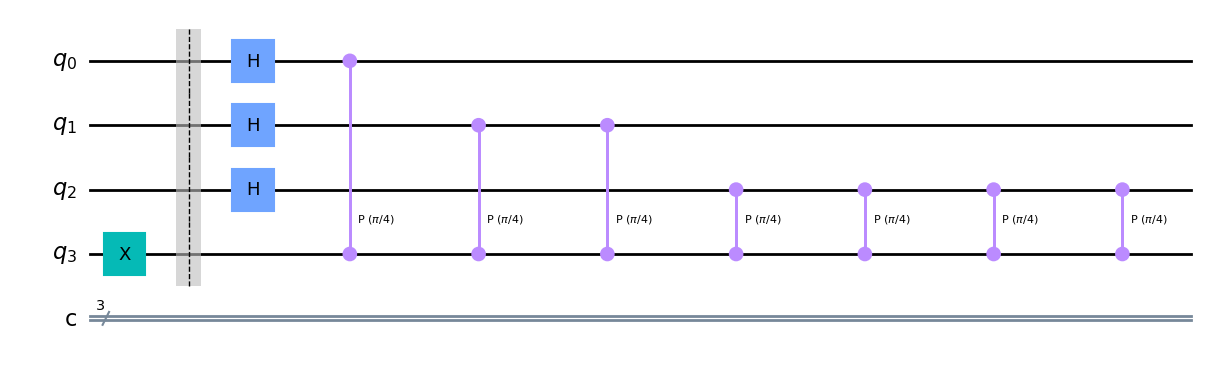

In [4]:
repetitions = 1
for counting_qubit in range(t):
    for i in range(repetitions):
        qpe.cp(np.pi/4, counting_qubit, t); # Puerta C-T
    repetitions *= 2
qpe.draw('mpl')

We can define a function for the inverse of the QFT

In [5]:
def qft_dagger(qc, n):
    """QFTdagger of n-qubits for the qubits from 0 to n-1"""
    # The circuit is the inverse of a QFT of 3 qubits
    # In this case, the swaps are at the beginning
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)

We add the $\text{QFT}^\dagger$ to the circuit and the measurements

In [6]:
qpe.barrier()
# Apply the inverse QFT
qft_dagger(qpe, t)
# Apply the measurements
qpe.barrier()
for n in range(t):
    qpe.measure(n,n)

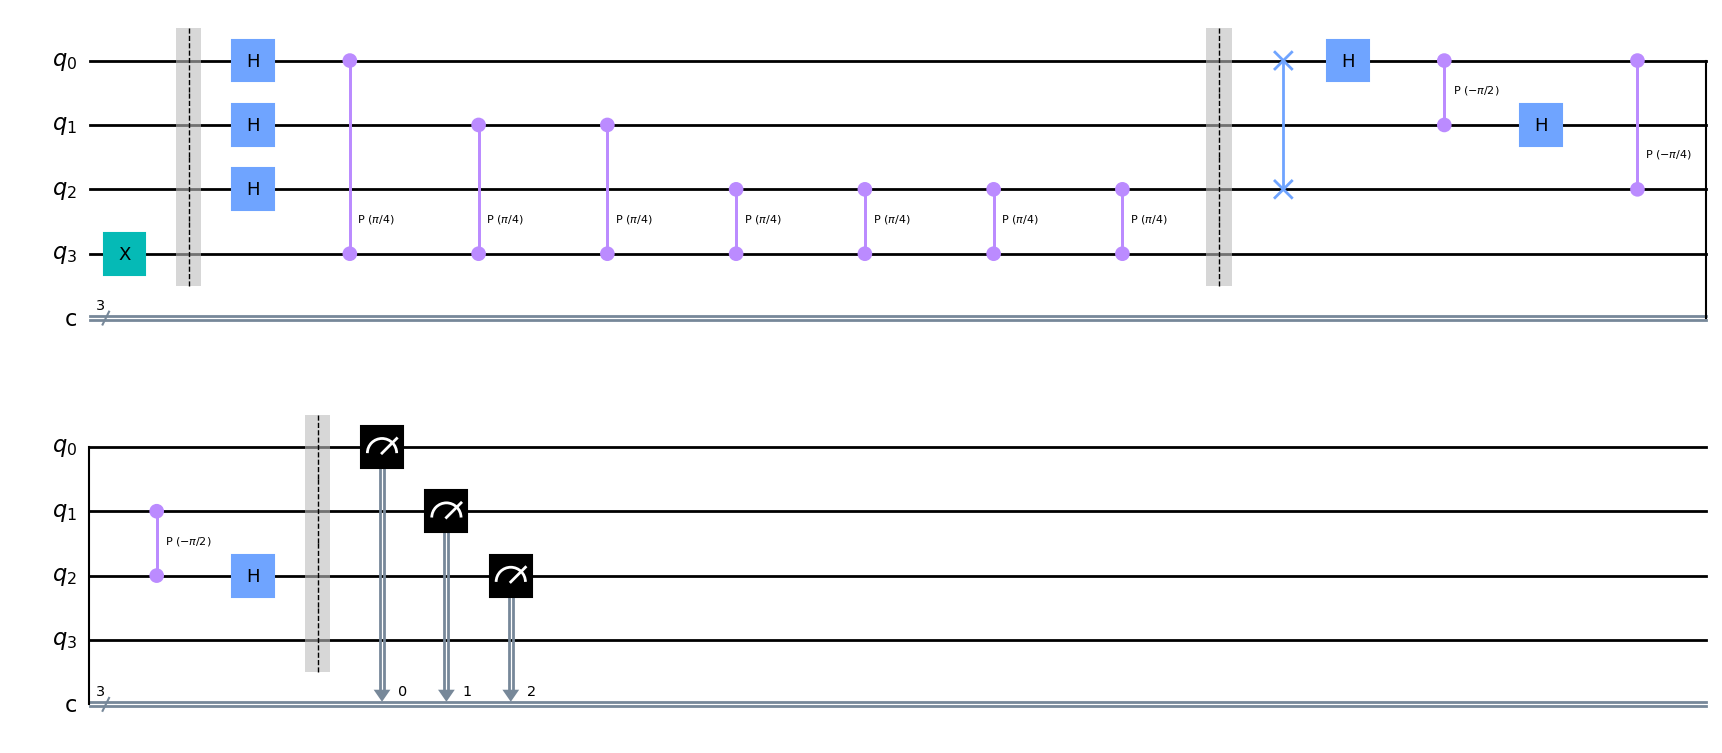

In [7]:
qpe.draw('mpl')

Execute the simulator and measure the results

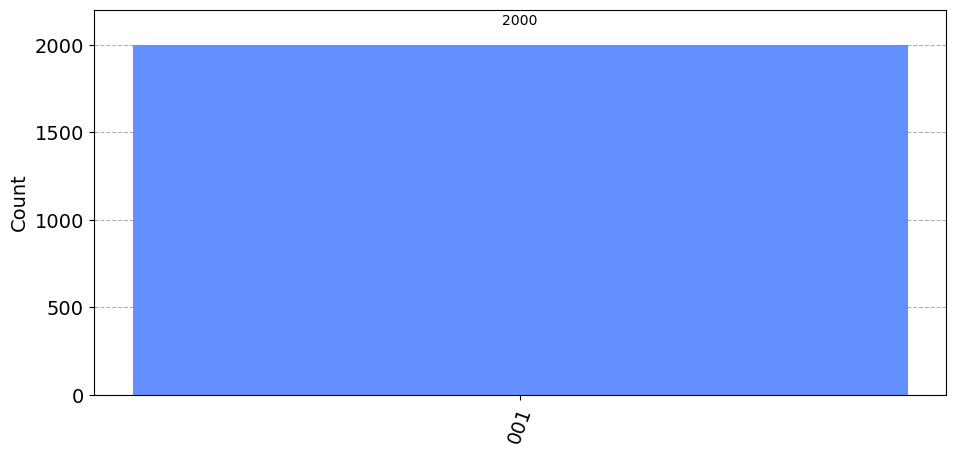

In [8]:
def measure_qpe(qc):
    sim = AerSimulator()
    shots = 2000
    results = execute(qc, sim, shots=shots).result()
    answer = results.get_counts()
    display(plot_histogram(answer, figsize=(11,5)))

measure_qpe(qpe)

The result is $\tilde{\theta}=1$. Remember that the output of the QPE algorithm is $2^t\theta$. In this case $t=3$, so $\theta = \frac{\tilde{\theta}}{2^t} = \frac{1}{8}$ 

We can obtain the two eigenvalues of $T$ with a circuit. The eigenvectors of $T$ are $\{|0\rangle,|1\rangle\}$, and their eigenvalues are $\lambda_0 = 1$ and $\lambda_1=e^{i\frac{\pi}{4}}$, so $\theta_0=0$ and $\theta_1=1/8$.



# Task QPE-1

We take as input of the algorithm the superposition of the eigenvectors of $T$: $|\psi\rangle = \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$. The expected output will be:

$$
\frac{1}{\sqrt{2}}(\lambda_0|0\rangle+\lambda_1|1\rangle) = \frac{1}{\sqrt{2}}(|0\rangle+e^{i\frac{\pi}{4}}|1\rangle)
$$

Write a function *qpe_circ* that receives two parameters: *phase* and *t*, where $phase$ 
    is the phase of the controlled rotation, and *t* is the number of ancilla qubits.

The next code uses your *qpe_circ* implementation

In [9]:
t = 3
qpe = QuantumCircuit(t+1, t)  # 4 qubits and 3 classical bits to measure the ancillas
qpe.h(t)    # Initial state 1/\sqrt(2)(|0>+|1>)
qpe.barrier()
qpe = qpe.compose(qpe_circ(np.pi/4, t))
qpe.draw('mpl')

NameError: name 'qpe_circ' is not defined

In [ ]:
measure_qpe(qpe)

Both values should be eigenvalues of  T (000 and 001).

Repeat the circuit with a phase gate of $2\pi/3$:

$$ U|1\rangle = 
\begin{bmatrix}
1 & 0\\
0 & e^\frac{2i\pi}{3}\\ 
\end{bmatrix}
\begin{bmatrix}
0\\
1\\ 
\end{bmatrix}
= e^\frac{2i\pi}{3}|1\rangle = e^{2i\pi\theta}|1\rangle$$

so in this case $\theta = 1/3$


In [ ]:
t = 5
qpe = QuantumCircuit(t+1, t)  # 6 qubits and 5 classical qubits to measure the ancillas
qpe.x(t)    # Initial state |1>
qpe.barrier()
qpe = qpe.compose(qpe_circ(2*np.pi/3, t))
display(qpe.draw('mpl'))
measure_qpe(qpe)

In [ ]:
measure_qpe(qpe)

The expected output would be $\tilde{\theta} = 2^t\theta = 8/3=2.6666$ 

We see that, with higher probability, the circuit will return a 2 or a 3.

A 2 corresponds to $2^3\theta_2=2 \Rightarrow \theta_2 = 2/8 = 0.25$ and a 3 to $\theta_3 = 3/8 = 0.375$. The circuit is telling us that the correct value of $\theta$ is between those two.

We can increase the precision by putting more ancilla bits:


In [ ]:
t = 5
qpe = QuantumCircuit(t+1, t)  # 6 qubits and 5 classical qubits to measure the ancillas
qpe.x(t)    # Initial state |1>
qpe.barrier()
qpe = qpe.compose(qpe_circ(2*np.pi/3, t))
display(qpe.draw('mpl'))
measure_qpe(qpe)

The two most likely measurements are $01010=10$ and $01011 = 11$, which correspond to values of $\theta$:

$$
\theta_{10} = \frac{10}{2^5} = 0.3125\\
\theta_{11} = \frac{11}{2^5} = 0.34375
$$

These values are very close to the true value of $\theta = 1/3 \approx 0.3333$. We can see that increasing the number of ancilla qubits improves the precision of the QPE algorithm. However, there is a trade-off between the precision and the number of controlled operations required, which increases exponentially with the number of ancilla qubits. 


If we test a negative eigenvalue

In [ ]:
t = 5
qpe = QuantumCircuit(t+1, t)  # 6 qubits and 5 classical bits to measure the ancillas
qpe.x(t)    # Initial state |1>
qpe.barrier()
qpe = qpe.compose(qpe_circ(-2*np.pi/3, t))
measure_qpe(qpe)

the two most probable measurements are $10101 = -11$ and $10110 = -10$.

# Task QPE-2

In this exercise, you will implement the Quantum Phase Estimation (QPE) algorithm using Qiskit implementation *PhaseEstimation*. 

You are given a unitary operator U and an eigenstate $|\phi\rangle$ of U. The eigenvalue of  $|\phi\rangle$ is $e^{2\pi i\theta}$, where $\theta$ is unknown. Your task is to estimate the value of $\theta$ using the QPE algorithm.

You can use the following parameters:
- U = Z gate (Pauli-Z)
- $|\phi\rangle$ = $|1\rangle$ state
- Number of ancilla qubits = 4



## Expected Output

The Pauli-Z gate has eigenvalues ±1, so in our case, $\theta$ can be 0 or 0.5. Since $|\phi\rangle$ is an eigenstate of Z with eigenvalue -1, we expect $\theta = 0.5$.

After running the quantum circuit, you should measure the state |1000⟩ most of the time. This binary number corresponds to the decimal number 8. Since we have used 4 ancilla qubits, the estimated $\theta$ is $8/2^4 = 0.5$, which matches our expectation.

Implement using the [qiskit.circuit.library.PhaseEstimation](https://qiskit.org/documentation/stable/0.24/stubs/qiskit.circuit.library.PhaseEstimation.html) qiskit helper to implement the QPE


# Lab

Create a small notebook where you:
1. Implement a QPE for an U operator you design yourself. It is better if it is not a trivial one.
2. Use the QPE implementation of Qiskit to calculate its eigenvalues.
3. Check and discuss why the output you get is the right one. You can verify the outputs doing the calculations by hand or using numpy code.